In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
import sys
sys.path.append('..')

import GaussianODEs as ode

In [2]:
mu0 = 0
C0 = 1

mu = 0 
C = 100

In [3]:
def exact_wfr(mu, sigma, mu0, sigma0, t):
    C = sigma+((1/(sigma0-sigma)+1/(sigma+2))*np.exp(t*(1+2/sigma)) - 1/(sigma+2))**(-1)
    m = mu+(mu0-mu)*np.exp(t/sigma)*(C-sigma)/(sigma0-sigma)
    return m, C
def exact_fr(mu, sigma, mu0, sigma0, t):
    C = (1/sigma + np.exp(-t)*(1/sigma0-1/sigma))**(-1)
    m = mu + np.exp(-t)*C*(mu0-mu)/sigma0
    return m, C
def exact_w(mu, sigma, mu0, sigma0, t):
    C = np.exp(-2*t/sigma)*(sigma0+sigma*(np.exp(2*t/sigma)-1))
    m = np.exp(-t/sigma)*mu0 + mu*(1-np.exp(-t/sigma))
    return m, C

## Log-concavity constant

In [4]:
## exact WFR evolution 
discr = 1000
gamma = 0.01
mean_eq_wfrinf, var_eq_wfrinf = exact_wfr(mu, C, mu0, C0, np.arange(discr+1)*gamma)

Derivation of constants for Theorem 4.1:

Recall $V_0(x) = x^2/2$ and $V_\pi(x) = x^2/(2C_\pi) = \alpha_\pi x^2/2 $. Then, 
$$V_0(x) - \frac{(1+\delta)}{2}V_\pi(x) = \frac{x^2}{2}- \frac{\alpha_\pi(1+\delta)}{2}\frac{x^2}{2}$$
is strongly convex with parameter $\alpha_d = \frac{1}{2}-\alpha_\pi\frac{(1+\delta)}{4}>0$ for $\delta<2/\alpha_\pi-1$.

For $\mathcal{H}$ we compute
$$\mathcal{H}(x) = -\frac{\alpha_\pi}{2}+\frac{1}{4}\alpha_\pi^2x^2+\alpha_\pi\frac{x^2}{2}$$
which is strongly convex with parameter $\alpha_h = \alpha_\pi+\frac{\alpha_\pi^2}{4}$.

In [5]:
## evolution from Theorem 4.1
alphapi = 1/C
Lpi = 1/C

delta = 2/alphapi-1-0.1
alphad = 0.5-alphapi*(1+delta)/4
c0 = alphad+delta/2*alphapi

alphah = alphapi+alphapi**2/4
b = np.sqrt(0.5*(alphah-Lpi))


cinf1 = 0.5*(-1+np.sqrt(1+4*(alphapi/2-b**2)))
cinf2 = 0.5*(-1-np.sqrt(1+4*(alphapi/2-b**2)))
l0 = (c0-cinf1)/(c0-cinf2)

In [6]:
alpha_eq_theo = np.zeros(discr+1)
alpha_eq_theo[0] = 1/C0
for i in range(discr):
    t = gamma*(i+1)
    alpha_eq_theo[i+1] = alphapi/2 + (cinf1-cinf2*l0*np.exp(-t*(cinf1-cinf2)))/(1-l0*np.exp(-t*(cinf1-cinf2)))

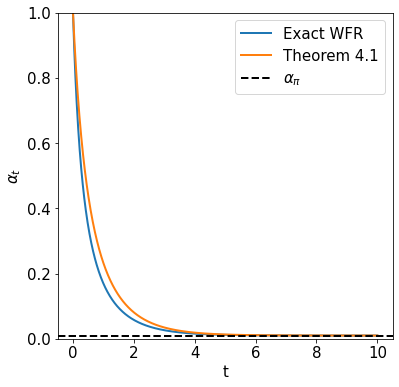

In [7]:
plt.figure(figsize = (6, 6))
plt.plot(gamma*np.arange(discr+1), 1/var_eq_wfrinf, label = 'Exact WFR', lw = 2)
plt.plot(gamma*np.arange(discr+1), alpha_eq_theo, label = 'Theorem 4.1', lw = 2)
plt.axhline(y=alphapi, color='black', linestyle='--', label = r'$\alpha_\pi$', lw = 2)
plt.legend(fontsize = 15)
plt.xlabel('t', fontsize = 15)
plt.ylabel(r'$\alpha_t$', fontsize = 15)
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
plt.ylim(0, 1);
# plt.savefig('alphat_1.pdf', bbox_inches="tight")

## Symmetrised KL decay

In [13]:
mu0 = 0
C0 = 1

mu = 20 
C = 100

## exact WFR evolution 
discr = 1000
gamma = 0.01
mean_eq_wfrinf, var_eq_wfrinf = exact_wfr(mu, C, mu0, C0, np.arange(discr+1)*gamma)
mean_eq_w, var_eq_w = exact_w(mu, C, mu0, C0, np.arange(discr+1)*gamma)
mean_eq_fr, var_eq_fr = exact_fr(mu, C, mu0, C0, np.arange(discr+1)*gamma)

In [14]:
## exact WFR decay
j_exact = np.zeros(discr+1)
kl_exact = np.zeros(discr+1)
kl_w = np.zeros(discr+1)
kl_fr = np.zeros(discr+1)
for i in range(discr+1):
    kl_exact[i] = ode.KL(mean_eq_wfrinf[i], var_eq_wfrinf[i], mu, C)
    kl_w[i] = ode.KL(mean_eq_w[i], var_eq_w[i], mu, C)
    kl_fr[i] = ode.KL(mean_eq_fr[i], var_eq_fr[i], mu, C)
    j_exact[i] = kl_exact[i] + ode.KL(mu, C, mean_eq_wfrinf[i], var_eq_wfrinf[i])

In [15]:
## Proposition 5.1
j_theo = np.zeros(discr+1)
j_theo[0] = ode.KL(mu0, C0, mu, C) + ode.KL(mu, C, mu0, C0)
for i in range(1, discr+1):
    t = gamma*i
    j_theo[i] = j_theo[0]*np.exp(-t*(1+alphapi))

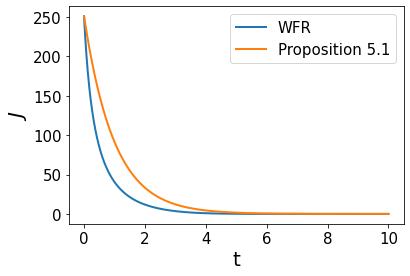

In [16]:
plt.plot(gamma*np.arange(discr+1), j_exact, label = 'WFR', lw = 2)
plt.plot(gamma*np.arange(discr+1), j_theo, label = 'Proposition 5.1', lw = 2)
plt.legend(fontsize = 15)
plt.xlabel('t', fontsize = 20)
plt.ylabel(r'$J$', fontsize = 20)
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
# plt.savefig('j_rate.pdf', bbox_inches="tight")

## KL decay

For one dimensional Gaussians $\mu_0 = \mathcal{N}(x; m_0, C_0)$ to target Gaussian $\pi = \mathcal{N}(x; m_\pi, C_\pi)$, we have $\lambda_\pi = C_\pi$ and $B=\max\{C_0+m_0^2, C_\pi+m_\pi^2\}$,
\begin{align*}
    \log \frac{\mu_0(x)}{\pi(x)} = \frac{C_0-C_\pi}{2C_0C_\pi}\left[\left(x+\frac{m_0C_\pi-m_\pi C_0}{C_0-C_\pi}\right)^2-\left(\frac{m_0C_\pi-m_\pi C_0}{C_0-C_\pi}\right)^2+\frac{m_\pi^2C_0-m_0^2C_\pi}{C_0-C_\pi}+\frac{C_0C_\pi}{C_0-C_\pi}\log\frac{C_\pi}{C_0}\right].
\end{align*}
Thus, if $C_0\neq C_\pi$ we can take
\begin{align*}
    M = \frac{\vert m_0^2C_\pi^2+m_\pi^2C_0^2-C_0C_\pi(m_0+m_\pi)^2\vert}{C_0C_\pi\vert C_0-C_\pi\vert}.
\end{align*}
Alternatively, (rougher but easier) since $m_0 = 0, C_0 = 1$
\begin{align*}
    -\frac{1}{2}(x^2+1)\leq\log \frac{\mu_0(x)}{\pi(x)} = -\frac{x^2}{2}+\frac{(x-m_\pi)^2}{2C_\pi} \leq \frac{m_\pi^2}{C_\pi}(x^2+1)
\end{align*}
and $M=\max\{1/2, m_\pi^2/C_\pi\}$.

In [40]:
## (5.2)
B = np.maximum(C0+mu0**2, C+mu**2)
M = np.maximum(1/2, mu**2/C)
# M = np.abs(mu0**2*C**2 + mu**2*C0**2 - C0*C*(mu0+mu)**2)/(C0*C*np.abs(C0-C)) 

B, M

(500, 4.0)

In [48]:
t = np.arange(discr+1)*gamma
kl52 = np.minimum(ode.KL(mu0, C0, mu, C)*np.exp(-2*t/C), M*np.exp(-t)*(2+B+B*np.exp(M*(1+B)*np.exp(-t))))

/var/folders/yb/2yx4lkb90l57vb9ljkzffpq40000gn/T/ipykernel_42212/3397476360.py:2: RuntimeWarning: overflow encountered in exp
  kl52 = np.minimum(ode.KL(mu0, C0, mu, C)*np.exp(-2*t/C), M*np.exp(-t)*(2+B+B*np.exp(M*(1+B)*np.exp(-t))))
/var/folders/yb/2yx4lkb90l57vb9ljkzffpq40000gn/T/ipykernel_42212/3397476360.py:2: RuntimeWarning: overflow encountered in multiply
  kl52 = np.minimum(ode.KL(mu0, C0, mu, C)*np.exp(-2*t/C), M*np.exp(-t)*(2+B+B*np.exp(M*(1+B)*np.exp(-t))))


In [68]:
## (5.3)
delta = 0.1
t0 = np.log(M/delta**3)
kl53 = ode.KL(mu0, C0, mu, C)*np.minimum(1, np.exp(-(t-t0)*(2/C+(2-3*delta))))

In [77]:
t0

8.294049640102028

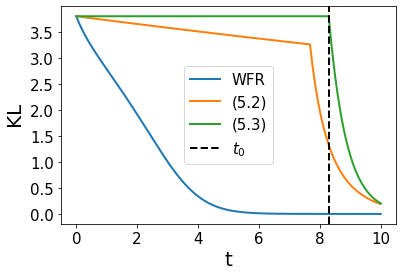

In [76]:
plt.plot(gamma*np.arange(discr+1), kl_exact, label = 'WFR', lw = 2)
plt.plot(gamma*np.arange(discr+1), kl52, label = '(5.2)', lw = 2)
plt.plot(gamma*np.arange(discr+1), kl53, label = '(5.3)', lw = 2)
plt.axvline(t0, color = 'black', label = r'$t_0$', linestyle = 'dashed', lw = 2)
plt.legend(fontsize = 15)
plt.xlabel('t', fontsize = 20)
plt.ylabel(r'$\mathrm{KL}$', fontsize = 20)
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
# plt.savefig('kl_rate.pdf', bbox_inches="tight")